In [ ]:
from pysolotools.converters.solo2coco import SOLO2COCOConverter
from pysolotools.consumers import Solo

In [ ]:
solo = Solo("Dataset/solo_1")
dataset = SOLO2COCOConverter(solo)
dataset.convert(output_path="Dataset/coco_1")

In [4]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)

        self.annIm_dict = defaultdict(list)        
        self.cat_dict = {} 
        self.annId_dict = {}
        self.im_dict = {}
        #self.licenses_dict = {}
        for ann in coco['annotations']:           
            self.annIm_dict[ann['image_id']].append(ann) 
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        #for license in coco['licenses']:
            #self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]        
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    #def get_imgLicenses(self,im_ids):
    #    im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
    #    lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
    #    return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [5]:
coco_annotations_file="./Dataset/coco_1/coco/bbox.json"
coco_images_dir="./Dataset/coco_1/coco/images"
coco= COCOParser(coco_annotations_file, coco_images_dir)

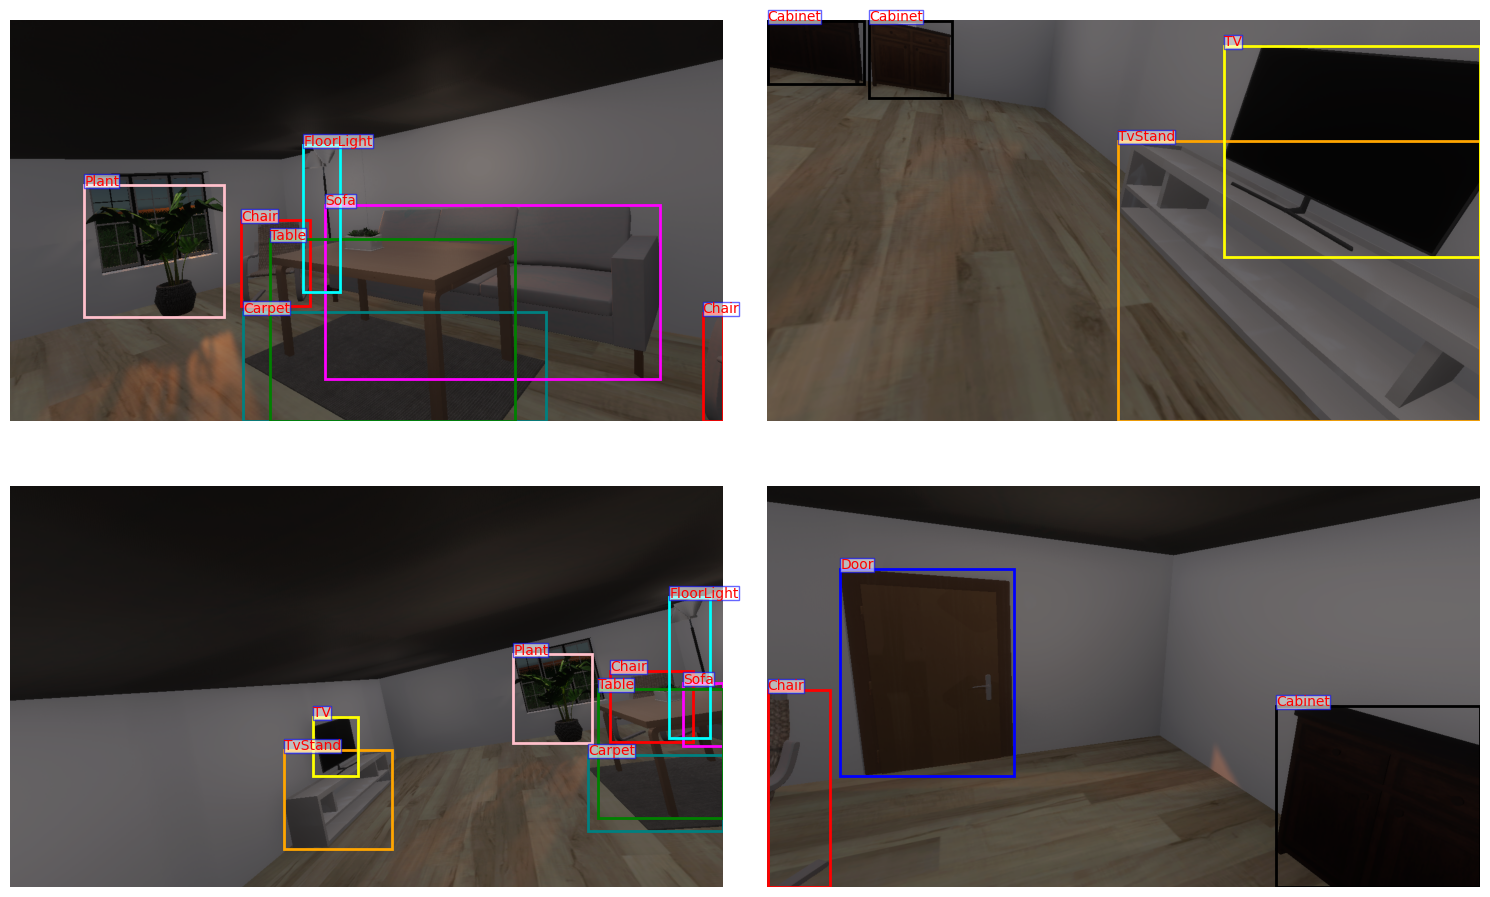

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
img_ids = coco.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]
ann_ids = coco.get_annIds(selected_img_ids)
#im_licenses = coco.get_imgLicenses(selected_img_ids)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{coco_images_dir}/camera_{str(im)}.png")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        #license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)

    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    #ax[i].set_title(f"License: {license}")
plt.tight_layout()
plt.show()

In [8]:
coco.im_dict

{0: {'id': 0, 'width': 1366.0, 'height': 768.0, 'file_name': 'camera_0.png'},
 1: {'id': 1, 'width': 1366.0, 'height': 768.0, 'file_name': 'camera_1.png'},
 2: {'id': 2, 'width': 1366.0, 'height': 768.0, 'file_name': 'camera_2.png'},
 3: {'id': 3, 'width': 1366.0, 'height': 768.0, 'file_name': 'camera_3.png'},
 4: {'id': 4, 'width': 1366.0, 'height': 768.0, 'file_name': 'camera_4.png'},
 5: {'id': 5, 'width': 1366.0, 'height': 768.0, 'file_name': 'camera_5.png'},
 6: {'id': 6, 'width': 1366.0, 'height': 768.0, 'file_name': 'camera_6.png'},
 7: {'id': 7, 'width': 1366.0, 'height': 768.0, 'file_name': 'camera_7.png'},
 8: {'id': 8, 'width': 1366.0, 'height': 768.0, 'file_name': 'camera_8.png'},
 9: {'id': 9, 'width': 1366.0, 'height': 768.0, 'file_name': 'camera_9.png'},
 10: {'id': 10,
  'width': 1366.0,
  'height': 768.0,
  'file_name': 'camera_10.png'},
 11: {'id': 11,
  'width': 1366.0,
  'height': 768.0,
  'file_name': 'camera_11.png'},
 12: {'id': 12,
  'width': 1366.0,
  'height':

In [9]:
def convert_bbox_coco2yolo(img_width, img_height, bbox):
    """
    Convert bounding box from COCO  format to YOLO format

    Parameters
    ----------
    img_width : int
        width of image
    img_height : int
        height of image
    bbox : list[int]
        bounding box annotation in COCO format: 
        [top left x position, top left y position, width, height]

    Returns
    -------
    list[float]
        bounding box annotation in YOLO format: 
        [x_center_rel, y_center_rel, width_rel, height_rel]
    """
    
    # YOLO bounding box format: [x_center, y_center, width, height]
    # (float values relative to width and height of image)
    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]

In [10]:
import os
import json
from tqdm import tqdm
import shutil

def make_folders(path="output"):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path


def convert_coco_json_to_yolo_txt(output_path, json_file):

    path = make_folders(output_path)

    with open(json_file) as f:
        json_data = json.load(f)

    # write _darknet.labels, which holds names of all classes (one class per line)
    label_file = os.path.join(output_path, "_darknet.labels")
    with open(label_file, "w") as f:
        for category in tqdm(json_data["categories"], desc="Categories"):
            category_name = category["name"]
            f.write(f"{category_name}\n")

    for image in tqdm(json_data["images"], desc="Annotation txt for each iamge"):
        img_id = image["id"]
        img_name = image["file_name"]
        img_width = image["width"]
        img_height = image["height"]

        anno_in_image = [anno for anno in json_data["annotations"] if anno["image_id"] == img_id]
        anno_txt = os.path.join(output_path, img_name.split(".")[0] + ".txt")
        with open(anno_txt, "w") as f:
            for anno in anno_in_image:
                category = int(anno["category_id"]) - 1
                bbox_COCO = anno["bbox"]
                x, y, w, h = convert_bbox_coco2yolo(img_width, img_height, bbox_COCO)
                f.write(f"{category} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

    print("Converting COCO Json to YOLO txt finished!")

In [11]:
convert_coco_json_to_yolo_txt("./Dataset/yolo_1", "./Dataset/coco_1/coco/bbox.json")

Annotation txt for each iamge: 100%|██████| 1000/1000 [00:00<00:00, 4697.35it/s]

Converting COCO Json to YOLO txt finished!
